## Stroke Classification using LSTM

### Load Data

In [23]:
import pandas as pd

df = pd.read_csv('../data/processed/processed_lstm_data.csv', index_col=0)

### Preparing the LSTM Model

In [24]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Convert stroke labels to one-hot encoding
labels = to_categorical(df['stroke'])

# Define a function to create sequences from the data
def create_sequences(data, labels, sequence_length):
    X, y = [], []

    # Iterate through the data to create sequences of the specified length
    for i in range(len(data) - sequence_length + 1):
        
        # Append a new sequence of data from position i to i + sequence_length to X
        window = data[i:i + sequence_length]

        # Append the label corresponding to the end of the sequence to y
        label_window = labels[i:i + sequence_length]

        # If all labels are the same in the window, then add it to the y
        # This prevents mislabeling of the training data as the window includes the transition from
        # swimming to turning
        if np.all(label_window == label_window[0]):
            X.append(window)
            y.append(label_window[0])

        else:
            soft_label = np.mean(label_window, axis=0)
            X.append(window)
            y.append(soft_label)

    return np.array(X), np.array(y)

# Create sequences of data
sequence_length = 40
features = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
data = df[features].values
X, y = create_sequences(data, labels, sequence_length)

# Function to shuffle two np arrays in unison
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# Shuffle X and y in unison
X, y = unison_shuffled_copies(X, y)

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create and Train the LSTM Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense

model_lstm = Sequential()

# Add the first LSTM layer with 40 units
model_lstm.add(LSTM(40, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add a second LSTM layer with 40
model_lstm.add(LSTM(40))

# Add a fully connected layer that will output the predicted probabilities.
# The number of units equals the number of categories, using a softmax activation function
model_lstm.add(Dense(units=y_train.shape[1], activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#training the model
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/20


c:\Users\warren\Documents\PlatformIO\Projects\swimming_analysis\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


473/473 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.8551 - loss: 0.4333 - val_accuracy: 0.9209 - val_loss: 0.2485
Epoch 2/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - accuracy: 0.9383 - loss: 0.1733 - val_accuracy: 0.9530 - val_loss: 0.1271
Epoch 3/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.9646 - loss: 0.1002 - val_accuracy: 0.9673 - val_loss: 0.0946
Epoch 4/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.9767 - loss: 0.0665 - val_accuracy: 0.9911 - val_loss: 0.0403
Epoch 5/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.9822 - loss: 0.0558 - val_accuracy: 0.9946 - val_loss: 0.0232
Epoch 6/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.9918 - loss: 0.0286 - val_accuracy: 0.9964 - val_loss: 0.0195
Epoch 7/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - accuracy: 0.9837 - loss: 0.0543 - val_accuracy: 0.9994 - val_loss: 0.0147
Epoch 8/20
473/473 ━━━━━━━━━━━━━━━━━━━━ 31s 66ms/step - accuracy: 0.9903 - loss: 0.0344 - val_accurac

### Generate a Report

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generate predictions for the test set
y_pred = model_lstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
report = classification_report(y_test_classes, y_pred_classes)
print(report)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1053
           1       1.00      1.00      1.00       992
           2       1.00      0.99      0.99      1128
           3       1.00      1.00      1.00      1030

    accuracy                           1.00      4203
   macro avg       1.00      1.00      1.00      4203
weighted avg       1.00      1.00      1.00      4203



### Generate a Confusion Matrix

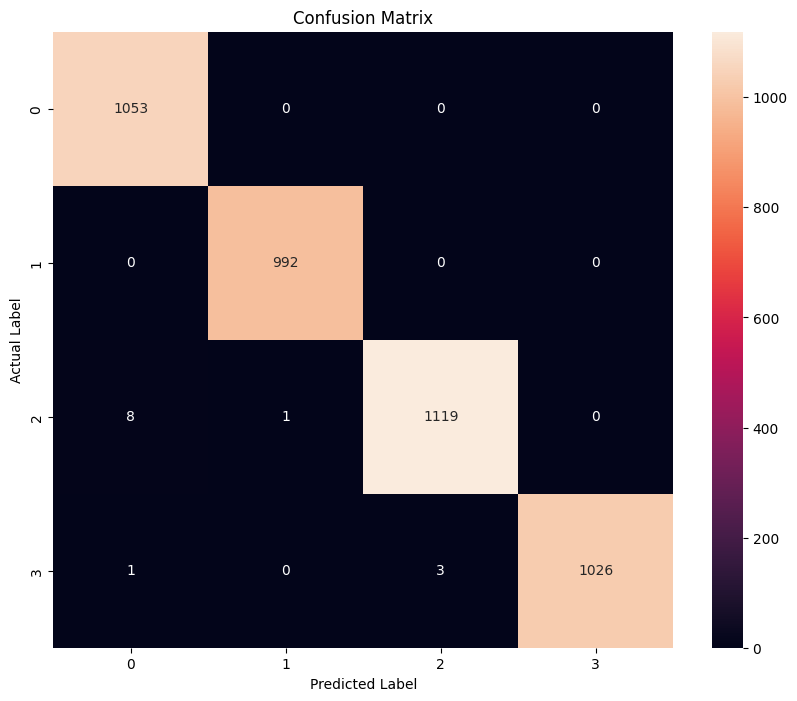

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()